###### DQN算法

## 简介

在之前学习的Q-learning算法中，我们以矩阵的方式建立了一张存储每个状态下所有动作$Q$值的表格。表格中的每一个动作价值$Q(s,a)$估计的是在状态$s$下选择动作$a$然后继续遵循某一策略预期能够得到的期望回报。然而这种用表格存储动作价值只能适用于环境的状态和动作是离散的，并且空间都比较小的时候。我们之前代码实战的几个环境都是如此，例如Cliff Walking。但是，当状态或者动作数量非常大的时候，这就并不适用了。例如，当状态是一个RGB图像时，假设图像大小是$210\times160\times3$，此时状态的数量一共有$256^{(210\times 60\times 3)}$种，在计算机种存储这个数量级的Q表格是不现实的。更甚者，当状态或者动作是连续的时候，就有无限个状态动作对，我们更加无法使用这种表格的形式来记录各个状态动作对的Q值。面对这种情况，我们需要用函数拟合的方法来进行估计。我们今天要介绍的DQN算法便可以用来解决连续状态下离散动作的问题。

## CartPole环境
例如下面介绍的[CartPole](https://github.com/openai/gym/wiki/CartPole-v0)环境中，它的状态值就是连续的，动作值是离散的。
<img src="https://staticcdn.boyuai.com/user-assets/358/qFardxgjocHVEhCr3nN8ka/qfoeot44j3.gif" width = "300" height = "300" align=center />
 
<center>CartPole环境 </center>

**状态参数**（每个维度都是连续值）

维度 | 意义 | 最小值 | 最大值
---|---|---|---
0 | 车的位置 | -2.4 | 2.4
1 | 车的速度 | -Inf | Inf
2 | 杆的角度 | ~ -41.8&deg; | ~ 41.8&deg;
3 | 杆尖端的速度 | -Inf | Inf

**动作参数**（离散）：

标号 | 动作
--- | ---
0 | 向左移动小车
1 | 向右移动小车

在CartPole环境中，有一辆小车，智能体的任务是左右移动来保持车上的杆竖直，若杆子倾斜度数过大或车子离初始位置左右偏离程度过大，或者坚持时间到达两百帧，则游戏结束。智能体的状态是一个维数为4的向量，每一维都是连续的，动作是离散的，动作空间大小为2。在游戏中每坚持一帧，智能体能获得1的奖励，所以坚持时间越长，则最后的分数越高，最多便是坚持两百帧。

## DQN算法
为了在类似CartPole的环境得到动作价值函数$Q(s,a)$，由于状态每一维度都是连续的，我们无法使用表格记录，一个常见的解决方法便是使用函数拟合（Function Approximation）的思想。由于神经网络强大的表达能力，我们可以用一个神经网络来表示$Q$函数。若动作是无限的，神经网络的输入是状态$s$和动作$a$，然后输出一个标量，表示在状态$s$下采取动作$a$能获得的价值。若动作是有限的，除了可以这样做，我们还可以只输入状态$s$，输出每一个动作的$Q$值。但通常DQN只能处理有限动作的情况，因为在Q函数更新过程中有max操作。假设神经网络用来拟合$Q$函数的参数是$\omega$，即对于每一个状态$s$下所有可能动作$a$的$Q$值我们都能表示为$Q_\omega(s,a)$。由于使用神经网络来拟合$Q$函数，我们称之为$Q$网络。那么$Q$网络的损失函数是什么呢？

我们先来回顾以下Q-learning的更新规则：

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'\in \mathcal{A}}Q(s',a') - Q(s,a) \right]
$$
它是在用TD目标$r + \gamma \max_{a'\in \mathcal{A}}Q(s',a')$来增量更新$Q(s,a)$，也就是说我们要$Q(s,a)$和TD目标$r + \gamma \max_{a'\in \mathcal{A}}Q(s',a')$靠近。于是对于一组数据$\{(s_i, a_i, s_i', r_i)\}$我们很自然地可以构造$Q$网络的损失函数为一个均方误差的形式

$$
\omega^{*} = \arg \min _{\omega} \frac{1}{2N} \sum_{i=1}^N \left[Q_{\omega}\left(s_i, a_i\right)-\left(r_i+\gamma \max _{a^{\prime}} Q_{\omega}\left(s'_i, a^{\prime}\right)\right)\right]^{2}
$$

至此我们就可以将Q-learning扩展到神经网络形式，我们称这种方法为DQN（Deep Q Network）算法。由于DQN是离线策略算法，我们在收集数据的时候可以使用一个$\epsilon$-greedy策略。在DQN中，还有两个非常重要的模块，它们帮助DQN取得稳定出色的性能。它们分别是经验回放和目标网络。

### 经验回放（Experience Replay）

在通常的监督学习中，我们假设训练数据是独立同分布的，我们每次训练神经网络的时候是从训练数据中随机采样一个或若干个数据来进行梯度下降，随着学习的不断进行，每一个训练数据会被使用多次。在原先的Q-learning算法中，每一个数据只会用来更新一次Q值。于是，为了更好的将Q-learning和深度神经网络结合，DQN算法采用了经验回放的策略。具体做法为维护一个回放池（replay buffer），每次从环境中采样到四元组数据（状态-动作-下一状态-奖励）$（s_t, a_t, s_{t+1}, r_t）$会存储到回放池中，训练$Q$网络的时候再从回放池中随机采样若干数据来进行训练。这么做可以达到两个作用。一是在MDP中采样得到的数据本身不满足独立的假设，因为这一时刻状态和上一时刻的状态有关，采用经验回放可以打破样本之间的相关性，让其满足独立假设。二是每一个样本可以被使用多次，提高样本利用率。

### 目标网络（Target Network）
此外，由于DQN算法中最终更新的目标是让$Q_{\omega}\left(s, a\right)$逼近$r+\gamma \max _{a^{\prime}} Q_{\omega}\left(s', a^{\prime}\right)$，但TD目标本身就包含了神经网络的输出，在更新网络参数的同时目标也在不断地改变，这非常容易造成训练的不稳定性。为了解决这一问题，在DQN中，便使用了目标网络的思想。既然训练过程中$Q$网络的不断更新会导致目标不断发生改变的话，我们不如暂时先将TD目标中的$Q$网络固定住。为了实现这一思想，我们需要利用两套$Q$网络

1. 原先的训练网络$Q_\omega (s,a)$，用于计算原先损失函数$\frac{1}{2}\left[Q_{\omega}\left(s, a\right)-\left(r+\gamma \max _{a^{\prime}} Q_{\omega^-}\left(s', a^{\prime}\right)\right)\right]^{2}$中的$Q_{\omega}\left(s, a\right)$项，并且使用正常梯度下降方法来进行更新。
2. 目标网络$Q_{\omega^-} (s,a)$，用于计算原先损失函数$\frac{1}{2}\left[Q_{\omega}\left(s, a\right)-\left(r+\gamma \max _{a^{\prime}} Q_{\omega^-}\left(s', a^{\prime}\right)\right)\right]^{  2}$中的$\left(r+\gamma \max _{a^{\prime}} Q_{\omega^-}\left(s', a^{\prime}\right)\right)$项。我们用$\omega^-$表示目标网络中的参数。如果两套网络的参数一直保持一致，则仍为原先不够稳定的算法。为了让更新目标更稳定，目标网络并不会每一步都更新。具体而言，目标网络使用训练网络的一套较旧的参数，在每一步下我们都会更新训练网络$Q_\omega (s,a)$，而只有每隔C步目标网络的参数才会与训练网络同步一次，即$\omega^- \leftarrow \omega$。这样保证了目标网络相对于训练网络变化更加稳定。

综上所述，DQN算法的流程如下

- 用随机的网络参数$\omega$初始化网络$Q_\omega(s,a)$
- 复制相同的参数$\omega'\leftarrow\omega$初始化目标网络$Q_{\omega'}$
- 初始化经验回放缓冲区$R$
- **for** 序列$e=1\to M$ **do**
- $\quad$获取环境初始状态$s_1$
- $\quad$ **for** $t=1\to T$ **do**
- $\quad\quad$根据当前网络$Q_\omega(s,a)$以$\epsilon$-greedy选择动作$a_t$
- $\quad\quad$执行动作$a_t$，获得回报$r_t$，环境状态变为$s_{t+1}$
- $\quad\quad$将$(s_t,a_t,r_t,s_{t+1})$存储进回放缓冲区$R$
- $\quad\quad$若$R$中数据足够，从$R$中采样$N$个数据$(s_i,a_i,r_i,s_{i+1})$
- $\quad\quad$对每个数据，用目标网络计算$y_i=r_i+\gamma \max_a Q_{\omega'}(s_{i+1},a)$
- $\quad\quad$最小化目标损失$L=\frac1N\sum_i(y_i-Q_\omega(s_i,a_i))^2$，以此更新当前网络$Q_\omega(s,a)$
- $\quad\quad$更新目标网络
- $\quad$ **end for**
- **end for**

## DQN代码实践

接下来，我们就开始正式进入DQN算法的代码实践环节，我们采用的测试环境CartPole-v0的状态空间相对简单，只有4个变量，因此我们的网络结构设计也相对简单。采用一层128个神经元的全连接并以ReLU作为激活函数。当遇到更复杂的诸如以图像作为输入的环境时，我们可以考虑采用深度卷积网络。

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

C:\Users\D.Guo\anaconda3\envs\tf-gpu\lib\site-packages\numpy\__init__.py:148: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. Please install mkl-service package, see http://github.com/IntelPython/mkl-service
  from . import _distributor_init


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "C:\Users\D.Guo\anaconda3\envs\tf-gpu\python.exe"
  * The NumPy version is: "1.21.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: 找不到指定的模块。


我们首先定义经验回放池的类，主要包括加入数据、采样数据两大函数。

In [2]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) # 队列，先进先出

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) # 将数据加入buffer

    def sample(self, batch_size): # 从buffer中采样数据，数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions) #returns an iterator of tuples, where the i-th tuple contains the i-th element from each of the argument iterables
        return np.array(state), action, reward, np.array(next_state), done 
    
    def size(self): # 目前buffer中数据的数量
        return len(self.buffer)

接下来是只有一层隐藏层的Q网络。

In [3]:
class Qnet(torch.nn.Module):
    ''' 一层隐层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

然后进入正题，开始我们的DQN算法代码。

In [4]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) # Q网络
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device) # 目标网络
        self.optimizer= torch.optim.Adam(self.q_net.parameters(), lr=learning_rate) # 使用Adam优化器
        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # epsilon-greedy
        self.target_update = target_update # 目标网络更新频率
        self.count = 0 # 计数器，记录更新次数
    
    def take_action(self, state): # epsilon greedy策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float)
        actions =  torch.tensor(transition_dict['actions']).view(-1, 1)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1)

        q_values = self.q_net(states).gather(1, actions) # Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) # 下个状态的最大Q值
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) # TD目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets)) # 均方误差损失函数
        self.optimizer.zero_grad()
        dqn_loss.backward() # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) # 更新目标网络
        self.count += 1

一切准备就绪，开始训练，并且查看结果。我们之后会将训练过程包装进rl_utils中，方便之后要学习的算法的代码实现。

In [5]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                if replay_buffer.size() > minimal_size: # 当buffer数据数量超过一定值后，才进行Q网络训练
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

Iteration 9: 100%|████████████████████████████████████████| 50/50 [00:12<00:00,  3.87it/s, episode=500, return=185.000]


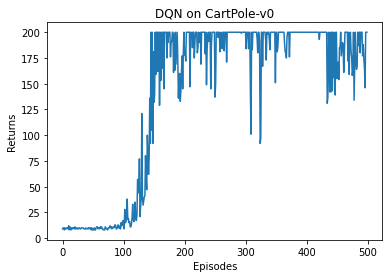

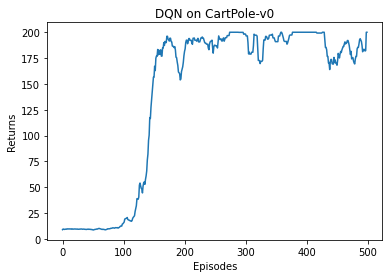

In [10]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list,return_list)
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('DQN on {}'.format(env_name))  
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')   
plt.ylabel('Returns')  
plt.title('DQN on {}'.format(env_name))  
plt.show()

## 以图像为输入的DQN算法
在之前所有的强化学习环境中，我们使用的都是非图像的状态作为输入（比如上面环境中车的坐标、速度），但是在一些视频游戏过程中并不能直接获取这些状态信息，智能体能够直接获取的是屏幕中的图像，如果要让智能体和人一样玩游戏，我们需要让智能体学会以图像作为状态的决策。此时我们可以利用DQN算法，并且将卷积网络加入我们的网络结构以提取图像特征，最终实现以图像为输入的强化学习。以图像为输入的DQN算法代码，与以上代码不同之处主要在于$Q$网络的结构和数据输入，其他并无明显区别。通常会将最近几帧图像一起作为DQN网络的输入，不只使用一帧是为了感知环境的动态性。接下来我们看一下以图像为输入的DQN算法代码，但由于需要运行较久时间，我们在此便不展示训练结果。

In [48]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = x.float() / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.head(x)

## 总结

在本章节内容中，我们学习了DQN算法，主要思想是用一个神经网络来建模最优策略的$Q$函数，然后利用Q-learning的思想进行参数更新。在DQN中，为了训练的稳定性和高效性，引入了经验回放和目标网络两大模块，使得实际算法在应用时取得更好的效果。DQN作为深度强化学习的基础，掌握该算法才算是真正入门了深度强化学习，我们面前将有更多的深度强化学习算法等待我们探索。